In [1]:
import torch
import clip
from PIL import Image
import numpy as np

/home/hongyu/iGitRepo/Point-TDA/notebook/clip/clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:
classnames = [    "a point cloud depth map of an airplane",
    "a point cloud depth map of a bathtub",
    "a point cloud depth map of a bed",
    "a point cloud depth map of a bench",
    "a point cloud depth map of a bookshelf",
    "a point cloud depth map of a bottle",
    "a point cloud depth map of a bowl",
    "a point cloud depth map of a car",
    "a point cloud depth map of a chair",
    "a point cloud depth map of a cone",
    "a point cloud depth map of a cup",
    "a point cloud depth map of a curtain",
    "a point cloud depth map of a desk",
    "a point cloud depth map of a door",
    "a point cloud depth map of a dresser",
    "a point cloud depth map of a flower pot",
    "a point cloud depth map of a glass box",
    "a point cloud depth map of a guitar",
    "a point cloud depth map of a keyboard",
    "a point cloud depth map of a lamp",
    "a point cloud depth map of a laptop",
    "a point cloud depth map of a mantel",
    "a point cloud depth map of a monitor",
    "a point cloud depth map of a night stand",
    "a point cloud depth map of a person",
    "a point cloud depth map of a piano",
    "a point cloud depth map of a plant",
    "a point cloud depth map of a radio",
    "a point cloud depth map of a range hood",
    "a point cloud depth map of a sink",
    "a point cloud depth map of a sofa",
    "a point cloud depth map of a stairs",
    "a point cloud depth map of a stool",
    "a point cloud depth map of a table",
    "a point cloud depth map of a tent",
    "a point cloud depth map of a toilet",
    "a point cloud depth map of a tv stand",
    "a point cloud depth map of a vase",
    "a point cloud depth map of a wardrobe",
    "a point cloud depth map of a xbox",]

In [8]:
pc_views = 'modelnet40_views'
pc_id = 2001
view_id = 6

In [9]:
# NOTE modelnet_c_views
# with open('../data/pc_views/modelnet_c_views/add_global_2/labels.txt') as fin:
#     labels = [line.strip() for line in fin.readlines()]

In [10]:
# NOTE modelnet40_views
with open('../data/pc_views/modelnet40_views/labels.txt') as fin:
    labels = [line.strip() for line in fin.readlines()]

In [11]:
device = "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

print('Data augmentations:\n', preprocess)

image = preprocess(Image.open(f"../data/pc_views/{pc_views}/{pc_id}/view_{view_id}.png")).unsqueeze(0).to(device)
text = clip.tokenize(classnames).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("probs.shape:", probs.shape)
print("Label probs:\n", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
print("True class index: ", labels[pc_id])
print("True class name: ", classnames[int(labels[pc_id])])
print("Predicted class index: ", int(probs.argmax(axis=1)))
print("Predicted class name: ", classnames[int(probs.argmax(axis=1))])

Data augmentations:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x74864615b310>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
probs.shape: (1, 40)
Label probs:
 [[0.00439463 0.0038895  0.00917704 0.00491583 0.04236149 0.05109557
  0.03956486 0.01244835 0.02786525 0.01026884 0.02281338 0.00126822
  0.07321183 0.0018717  0.0273155  0.03384678 0.00696062 0.01341383
  0.1289061  0.02636272 0.01455802 0.01171889 0.03612819 0.03063097
  0.00452032 0.01667742 0.00746941 0.01157869 0.05807472 0.00778406
  0.00921477 0.00405925 0.08644333 0.02791046 0.00215237 0.00964898
  0.02500031 0.06172973 0.01034908 0.02239894]]
True class index:  17
True class name:  a point cloud depth map of a guitar
Predicted class index:  18
Predicted class name:  a point cloud depth map of a keyboard


In [12]:
def avg_entropy(outputs):
    '''
        Do not understand why the following operations can compute `average entropy`?
    '''
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

In [13]:
output = torch.from_numpy(probs)
loss = avg_entropy(output)
print('loss:', loss)

loss: tensor(3.6885)


In [14]:
import math

def get_entropy(loss):
    # clip_weights: (emb_dim, n_cls)
    # so `max_entropy` is a scalar
    max_entropy = math.log2(40)
    # NOTE float(x) requires x is a scalar, so `loss` is a scalar
    return float(loss / max_entropy)

In [15]:
prop_entropy = get_entropy(loss)
print('math.log2(40):', math.log2(40))
print('prop_entropy:', prop_entropy)    

# 根据这个 `prop_entropy` 及   
# entropy_threshold:
    # lower: 0.2
    # upper: 0.5 
# NOTE 这个预测不进 negative cache，这是合理的，因为是正确的预测
# 我发现计算出来的 prop_entropy 都差不多，不论是正确的预测，还是错误的预测
# 正确的预测，view_id:6，0.6929051876068115
# 错误的预测，view_id:9，0.6930482983589172

math.log2(40): 5.321928094887363
prop_entropy: 0.6930804252624512


### KMeans Clustering for the Output Sequence Tokens of Point Transformer  

In [4]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming your feature data is a numpy array of shape (512, 384)
# Replace this with your actual feature data
features = np.random.randn(512, 384)  # Example data

# Initialize KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the KMeans model to the feature data
kmeans.fit(features)

# Get the cluster labels for each feature
cluster_labels = kmeans.labels_

# To get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Output the cluster labels and centers
print("Cluster labels:", cluster_labels)
print("Cluster centers shape:", cluster_centers.shape)


/home/hongyu/miniconda3/envs/dassl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels: [3 0 4 1 4 3 4 1 3 3 0 3 0 0 2 2 2 0 4 3 1 1 3 2 4 2 3 3 2 4 3 2 2 4 2 4 3
 1 0 3 2 4 2 4 4 4 2 3 2 0 1 4 2 2 4 3 0 3 4 3 2 4 1 1 1 0 4 3 4 4 4 0 3 3
 2 0 3 2 4 1 4 4 0 4 4 4 1 2 4 3 0 4 3 4 3 3 0 4 4 4 1 3 2 3 4 4 4 3 2 1 4
 1 4 3 1 4 0 4 3 4 4 2 1 4 4 4 4 3 0 3 3 0 3 3 1 4 2 3 1 3 3 1 4 4 2 3 4 2
 0 4 0 2 3 4 4 4 0 2 3 3 0 2 4 3 1 3 3 3 3 4 2 2 4 2 4 3 4 2 3 4 2 0 1 1 1
 2 2 4 4 3 4 0 3 2 3 1 4 3 0 4 0 1 4 3 4 4 4 4 0 4 3 0 3 4 3 3 0 2 0 3 3 4
 2 4 1 1 2 2 0 4 2 3 4 4 4 1 4 1 4 1 3 2 3 3 1 4 4 4 4 4 3 3 4 0 1 3 4 4 3
 3 4 4 3 3 4 1 2 4 2 4 2 4 4 4 2 2 3 3 3 1 4 1 4 4 4 4 0 4 1 1 3 4 2 4 4 4
 0 3 2 3 1 1 2 4 0 3 2 3 0 0 1 4 4 3 3 4 4 1 4 4 3 1 4 3 4 0 4 1 2 3 2 3 2
 3 2 1 1 4 1 3 3 3 1 3 3 2 1 3 4 4 3 4 2 2 3 3 2 1 4 1 1 4 0 2 1 1 4 1 3 4
 3 4 3 1 0 0 3 3 3 4 0 4 4 1 4 4 0 1 1 4 1 4 1 4 4 0 1 4 4 4 3 3 1 4 0 0 0
 4 1 1 4 4 4 1 0 4 4 3 4 1 0 0 4 4 3 3 2 1 3 3 4 1 2 1 4 4 3 1 3 1 4 3 3 4
 3 4 4 4 3 1 4 4 3 0 4 1 4 1 1 4 4 1 3 1 1 2 4 4 2 2 4 2 2 4 0 3 2 4 1 3 0
 0 3 3 2 

In [5]:
print(cluster_centers[0])

[ 0.30344045 -0.12714556  0.01251591 -0.16790856  0.29574786 -0.09637338
 -0.24930782  0.12676164 -0.00820207 -0.05961631  0.05752391  0.02822934
  0.12234995  0.00843771 -0.43632113 -0.18309162 -0.15125865  0.09755724
  0.05977405 -0.12380929  0.11157309 -0.22319046 -0.11978507 -0.02349959
 -0.1802933  -0.12778518 -0.05891414 -0.43647163  0.10531359 -0.22091165
  0.13131059 -0.32840028  0.13040642  0.03469639 -0.38486554 -0.25403757
  0.19698873  0.38495567  0.17461255 -0.1666162  -0.03182224 -0.06148579
  0.1816087   0.29375403 -0.37878052  0.08345379 -0.00193227  0.20790002
 -0.21510457  0.12200791 -0.0432196  -0.04694096  0.01311613  0.12565876
 -0.09761696  0.06036383  0.16842084 -0.10893607 -0.08787352  0.22706079
 -0.12432617  0.01805573 -0.33624987 -0.18259962  0.34807678 -0.02056406
  0.03437179 -0.31595081  0.10828665 -0.20757238  0.0141839   0.24471265
 -0.36569665  0.01149068  0.01448548  0.1367153  -0.04567619  0.20458928
  0.05734828  0.18422792 -0.13701736 -0.2421063   0

In [3]:
type(cluster_centers)

numpy.ndarray

### Visualize KMeans Features

/home/hongyu/miniconda3/envs/dassl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


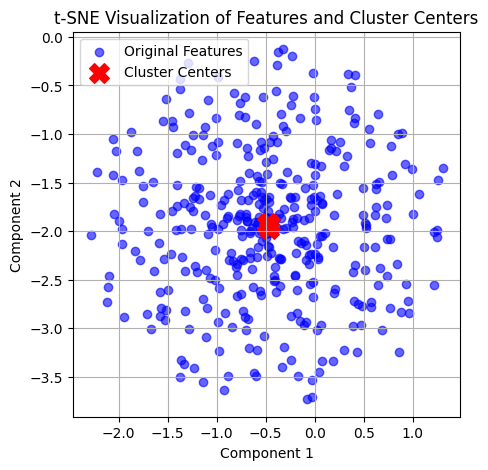

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Assume 'features' is a NumPy array of shape (384, 512)
features = np.random.randn(384, 512)

# Step 2: Apply KMeans to cluster the 384 features into 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(features)
cluster_centers = kmeans.cluster_centers_  # Shape: (5, 512)

# Step 3: Combine the original features and the cluster centers for t-SNE
combined_data = np.vstack([features, cluster_centers])  # Shape: (389, 512)

# Step 4: Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_data_2d = tsne.fit_transform(combined_data)  # Shape: (389, 2)

# Step 5: Split back the transformed data into original features and cluster centers
features_2d = combined_data_2d[:384]      # First 384 rows are the original features
centers_2d = combined_data_2d[384:]       # Last 5 rows are the cluster centers

# Step 6: Plot the original features and the cluster centers
plt.figure(figsize=(5, 5))

# Plot the original features
plt.scatter(features_2d[:, 0], features_2d[:, 1], c='blue', label='Original Features', alpha=0.6)

# Plot the cluster centers
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title("t-SNE Visualization of Features and Cluster Centers")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()


### Remove Image Encoder of Open_CLIP for OpenShape

In [1]:
import open_clip

In [2]:
clip_name = 'ViT-bigG-14'
open_clip_model, _, _ = open_clip.create_model_and_transforms(clip_name, 
    pretrained='../weights/openshape/open_clip_pytorch_model/vit-bigG-14/laion2b_s39b_b160k.bin')

In [3]:
sd = open_clip_model.state_dict()

In [5]:
for key in sd.keys():
    if key.startswith('visual.'):
        print(key)

visual.class_embedding
visual.positional_embedding
visual.proj
visual.conv1.weight
visual.ln_pre.weight
visual.ln_pre.bias
visual.transformer.resblocks.0.ln_1.weight
visual.transformer.resblocks.0.ln_1.bias
visual.transformer.resblocks.0.attn.in_proj_weight
visual.transformer.resblocks.0.attn.in_proj_bias
visual.transformer.resblocks.0.attn.out_proj.weight
visual.transformer.resblocks.0.attn.out_proj.bias
visual.transformer.resblocks.0.ln_2.weight
visual.transformer.resblocks.0.ln_2.bias
visual.transformer.resblocks.0.mlp.c_fc.weight
visual.transformer.resblocks.0.mlp.c_fc.bias
visual.transformer.resblocks.0.mlp.c_proj.weight
visual.transformer.resblocks.0.mlp.c_proj.bias
visual.transformer.resblocks.1.ln_1.weight
visual.transformer.resblocks.1.ln_1.bias
visual.transformer.resblocks.1.attn.in_proj_weight
visual.transformer.resblocks.1.attn.in_proj_bias
visual.transformer.resblocks.1.attn.out_proj.weight
visual.transformer.resblocks.1.attn.out_proj.bias
visual.transformer.resblocks.1.ln

In [6]:
keys_to_delete = [key for key in sd if key.startswith('visual')]
for key in keys_to_delete:
    del sd[key]

In [7]:
sd.keys()

odict_keys(['positional_embedding', 'text_projection', 'logit_scale', 'transformer.resblocks.0.ln_1.weight', 'transformer.resblocks.0.ln_1.bias', 'transformer.resblocks.0.attn.in_proj_weight', 'transformer.resblocks.0.attn.in_proj_bias', 'transformer.resblocks.0.attn.out_proj.weight', 'transformer.resblocks.0.attn.out_proj.bias', 'transformer.resblocks.0.ln_2.weight', 'transformer.resblocks.0.ln_2.bias', 'transformer.resblocks.0.mlp.c_fc.weight', 'transformer.resblocks.0.mlp.c_fc.bias', 'transformer.resblocks.0.mlp.c_proj.weight', 'transformer.resblocks.0.mlp.c_proj.bias', 'transformer.resblocks.1.ln_1.weight', 'transformer.resblocks.1.ln_1.bias', 'transformer.resblocks.1.attn.in_proj_weight', 'transformer.resblocks.1.attn.in_proj_bias', 'transformer.resblocks.1.attn.out_proj.weight', 'transformer.resblocks.1.attn.out_proj.bias', 'transformer.resblocks.1.ln_2.weight', 'transformer.resblocks.1.ln_2.bias', 'transformer.resblocks.1.mlp.c_fc.weight', 'transformer.resblocks.1.mlp.c_fc.bias'

In [9]:
for key in sd.keys():
    if not key.startswith('visual.') and not key.startswith('transformer'):
        print(key)

positional_embedding
text_projection
logit_scale
token_embedding.weight
ln_final.weight
ln_final.bias
